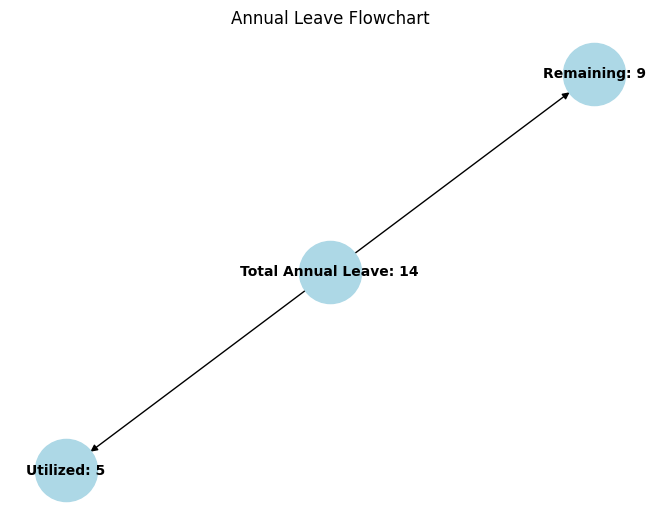

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
G.add_node("Total Annual Leave: 14")
G.add_node("Utilized: 5")
G.add_node("Remaining: 9")

G.add_edge("Total Annual Leave: 14", "Utilized: 5")
G.add_edge("Total Annual Leave: 14", "Remaining: 9")

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)

# Show the plot
plt.title("Annual Leave Flowchart")
plt.show()

In [8]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from operator import itemgetter
from langchain.memory import ConversationBufferMemory
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

openai_api_key = os.getenv("OPENAI_API_KEY")
chat = ChatOpenAI(
    temperature=0.5,
    model_name="gpt-3.5-turbo",
    openai_api_key=openai_api_key,
    max_tokens=100,
)
# Create a single memory instance for the entire conversation
memory = ConversationBufferMemory(return_messages=True)

def get_response(input_message, model, memory):
    prompt = ChatPromptTemplate.from_messages([
        ("system", """  You are a data analyst and working only employees data
                        Instructions:

                        1. Analyze Input: Evaluate the provided data or employee input to understand its structure and key elements. \n
                            only extract the information from the input which are employee data not a hr data or other data that is not a employee data. 
                        2. Decide Chart Type: Determine whether a  bar chart, or pie chart is more suitable based on the data that employee provided to you. \n
                            if user want or tell the name of specific chart then make this type chart if possible. 
                        

                        Example of Expected Output for a Bar Chart:

                        {
                            "chart_type": "bar",
                            "data_needed": {
                                "x-axis": {"categories": ["casual leave", "annual leave", "sick leave"], "label": "employee leaves fields"},
                                "y-axis": {"values": [10, 20, 5], "label": "employee leaves fields quantity"}
                            },
                            "chart_label": "Distribution of employee leaves information",
                            "axis_labels": {"x": "employee leaves fields", "y": "employee leaves fields quantity"}
                        }

                        Example of Expected Output for a Pie Chart:

                        {
                            "chart_type": "pie",
                            "data_needed": {
                                "categories": ["casual leave", "annual leave", "sick leave"],
                                "values": [10, 20, 5]
                            },
                            "chart_label": "Distribution of employee leaves information"
                        }
         
                        Example of Expected Output for a Network Chart Node:
                        {
                        "chart_type": "network",
                        "data_needed": {
                        "x-axis": {"categories": ["Total Annual Leave", "Utilized", "Remaining"], "label": "Annual Leave Fields"},
                        "y-axis": {"values": [14, 5, 9], "label": "Annual Leave Fields Quantity"}
                        },
                        "chart_label": "Distribution of employee leaves information",
                        "axis_labels": {"x": "Annual Leave Fields", "y": "Annual Leave Fields Quantity"}
                        }

                        Simply only give the required data.
                        """),
        MessagesPlaceholder(variable_name="history"),
        ("human", f"{input_message}"),
    ])

    chain = (
        RunnablePassthrough.assign(
            history=RunnableLambda(memory.load_memory_variables) | itemgetter("history")
        )
        | prompt
        | model
    )

    inputs = {"input": input_message}
    response = chain.invoke(inputs)

    # Save the context for future interactions
    memory.save_context(inputs, {"output": response.content})
    memory.load_memory_variables({})

    return response.content

In [9]:
input_message = "Who are you?"
get_response(input_message, chat, memory)

"I am an AI Assistant here to help you with any questions or information you may need. Feel free to ask me anything you'd like assistance with."

In [14]:
input_message = """
Here is your leaves data, Lisa: 

- Total Annual Leave: 14 days 
- Annual Leave Utilized: 3 days 
- Annual Leave Remaining: 11 days 

- Total Casual Leave: 10 days 
- Casual Leave Utilized: 9 days 
- Casual Leave Remaining: 1 day 

- Total Sick Leave: 10 days 
- Sick Leave Utilized: 0 days 
- Sick Leave Remaining: 10 days 

I want to see the leaves data.

"""
output = get_response(input_message, chat, memory)
print(output)

Here is the leaves data for Lisa:

- Annual Leave:
  - Total: 14 days
  - Utilized: 3 days
  - Remaining: 11 days

- Casual Leave:
  - Total: 10 days
  - Utilized: 9 days
  - Remaining: 1 day

- Sick Leave:
  - Total: 10 days
  - Utilized: 0 days
  - Remaining: 10 days

If you need any further
